In [11]:
import os
import time
import pandas as pd
import numpy as np
import datetime
import pymysql
from sqlalchemy import create_engine
import FinanceDataReader as fdr
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf
import warnings
warnings.filterwarnings('ignore')

# make_train_data

In [12]:
lst_code=[]
IF = open("code_list.txt", 'r')
for line in IF:
    code = line.strip('\n').split('\t')
    lst_code.append(code[0])
    
IF.close()

db_dsml = pymysql.connect(
    host = 'localhost', 
    port = 3306, 
    user = 'stock_user', 
    passwd = 'bigdata', 
    db = 'refined_stock', 
    charset = 'utf8'
)
cursor = db_dsml.cursor()

result = []

for code in tqdm(lst_code):
    sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date
                    BETWEEN '2017-11-01' AND '2020-12-31'
                    '''.format(code)
    
    stock = pd.read_sql(sql=sql_query, con=db_dsml)
    date_list = stock['Date']
    next_change_list = stock['Next Change']
    stock['trading_value'] = stock['Close'] * stock['Volume']
    
    stock = stock[['Open', 'High', 'Low', 'Close', 'MA5', 'MA20', 'MA60', 'MA120', 
                   'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
                   'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD', # scaling 필요 정보 24개
       'Volume','trading_value',
       'MFI', 'ADI', 'OBV',
       'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
       'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST',
       'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
       'WR', 'AO', 'ROC', 'PPO', 'PVO']]
    lst_stock=stock.values.tolist()

    
    # 스케일링
    scaled_stock_list=[]
    for i , row in enumerate(lst_stock):
        prev_close = lst_stock[i-1][3]
        
        scaled_inform=[]
        non_scaled_inform = row[24:]
        
        for value in row[:24]:
            scaled_inform.append( value / prev_close )
        
        scaled_stock_list.append(scaled_inform + non_scaled_inform)
    
        # 10일치 만들기
        
    for ii, (row2, date, next_change) in enumerate(zip(scaled_stock_list, date_list, next_change_list)):
        
        if (ii < 9) and next_change == None :
            continue
    
        if date <= pd.to_datetime('2018-01-01'):
            continue
        Close, MA5, MA20, MA60, MA120, Parabolic_SAR, trading_value = row2[3],row2[4],row2[5],row2[6],row2[7], row2[21],row2[25]
        
#         next_change = int(next_change >= 0.05)
        
        if  MA120 < MA60 < MA20 < MA5 and Close > Parabolic_SAR and trading_value >= 1000000000 :
            data_10_days = scaled_stock_list[ii-9:ii+1]
            day_10 = [date, code]

            for rows in data_10_days:
                day_10 += rows
            day_10 += [next_change]   
            result.append(day_10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1561/1561 [02:40<00:00,  9.71it/s]


In [13]:
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,...,543,544,545,546,547,548,549,550,551,552
0,2018-01-10,050120,1.000000,1.014583,0.951042,0.951042,1.071458,0.938906,0.885990,0.904236,...,0.648243,32.518764,56.433124,100.000000,-0.000000,3070.882353,27.731092,11.250316,23.017135,-0.148026
1,2018-01-11,050120,1.017525,1.088719,0.997809,1.063527,1.116977,0.994304,0.934903,0.951360,...,0.256848,29.314282,42.859786,39.024390,-60.975610,3348.823529,21.596244,11.064498,40.954190,0.057915
2,2018-01-12,050120,0.989701,1.204943,0.974253,1.060762,1.017302,0.943615,0.882492,0.895606,...,0.510099,28.137242,41.400996,46.646341,-53.353659,3463.676471,42.708333,11.262488,40.131842,0.124088
3,2018-01-15,050120,0.995146,1.169903,0.985437,1.145631,0.981359,0.903738,0.837006,0.846642,...,0.737437,29.322519,45.378723,63.922764,-36.077236,3645.882353,68.674699,12.324594,38.852000,-0.068182
4,2018-01-16,050120,1.012712,1.055085,0.923729,0.995763,0.893051,0.800720,0.735240,0.740960,...,0.493191,28.068878,45.640640,53.252033,-46.747967,3980.735294,47.785788,12.290200,30.627486,-0.188153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64005,2020-12-28,010690,1.001761,1.044014,0.996479,1.026408,1.007746,0.997887,0.992664,0.894968,...,0.369899,24.607776,42.847144,49.074074,-50.925926,421.544118,15.992970,4.227146,43.697292,-0.007576
64006,2020-12-29,010690,1.001715,1.005146,0.975986,0.984563,0.982161,0.973328,0.967439,0.874328,...,0.327847,24.012016,43.895120,45.497630,-54.502370,332.941176,15.114236,4.256760,32.761409,0.033588
64007,2020-12-30,010690,0.996516,1.006969,0.984321,0.991289,0.997561,0.989808,0.983130,0.890520,...,0.444204,24.740830,42.166975,55.924171,-44.075829,321.088235,19.190141,4.503539,25.552325,0.085672
64008,2018-06-05,000540,0.996759,1.004862,0.983793,0.996759,0.978606,0.950000,0.979849,0.969625,...,1.000000,17.781617,59.299397,83.333333,-16.666667,319.088235,8.403361,1.808703,15.046956,0.000000


In [14]:
np.save('/project/dsml2022/gksmf457/team_project/4th_scaled_trainset_parabol_ma.npy', result)

# make_test_data

In [15]:
lst_code=[]
IF = open("code_list.txt", 'r')
for line in IF:
    code = line.strip('\n').split('\t')
    lst_code.append(code[0])
    
IF.close()

db_dsml = pymysql.connect(
    host = 'localhost', 
    port = 3306, 
    user = 'stock_user', 
    passwd = 'bigdata', 
    db = 'refined_stock', 
    charset = 'utf8'
)
cursor = db_dsml.cursor()

result = []

for code in tqdm(lst_code):
    sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date
                    BETWEEN '2020-11-01' AND '2021-12-31'
                    '''.format(code)
    
    stock = pd.read_sql(sql=sql_query, con=db_dsml)
    date_list = stock['Date']
    next_change_list = stock['Next Change']
    stock['trading_value'] = stock['Close'] * stock['Volume']
    
    stock = stock[['Open', 'High', 'Low', 'Close', 'MA5', 'MA20', 'MA60', 'MA120', 
                   'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
                   'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD', # scaling 필요 정보 24개
       'Volume','trading_value',
       'MFI', 'ADI', 'OBV',
       'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
       'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST',
       'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
       'WR', 'AO', 'ROC', 'PPO', 'PVO']]
    lst_stock=stock.values.tolist()

    
    # 스케일링
    scaled_stock_list=[]
    for i , row in enumerate(lst_stock):
        prev_close = lst_stock[i-1][3]
        
        scaled_inform=[]
        non_scaled_inform = row[24:]
        
        for value in row[:24]:
            scaled_inform.append( value / prev_close )
        
        scaled_stock_list.append(scaled_inform + non_scaled_inform)
    
        # 10일치 만들기
        
    for ii, (row2, date, next_change) in enumerate(zip(scaled_stock_list, date_list, next_change_list)):
        
        if (ii < 9) and next_change == None :
            continue
    
        if date <= pd.to_datetime('2021-01-01'):
            continue
        Close, MA5, MA20, MA60, MA120, Parabolic_SAR, trading_value = row2[3],row2[4],row2[5],row2[6],row2[7], row2[21],row2[25]
        
#         next_change = int(next_change >= 0.05)
        
        if MA120 < MA60 < MA20 < MA5 and Close > Parabolic_SAR and trading_value >= 1000000000 :
            data_10_days = scaled_stock_list[ii-9:ii+1]
            day_10 = [date, code]

            for rows in data_10_days:
                day_10 += rows
            day_10 += [next_change]   
            result.append(day_10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1561/1561 [01:06<00:00, 23.44it/s]


In [16]:
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,...,543,544,545,546,547,548,549,550,551,552
0,2021-05-25,050120,0.993590,0.996795,0.977564,0.990385,0.975321,0.917708,0.804233,0.840458,...,0.816383,26.383392,54.956869,88.888889,-11.111111,522.750000,6.525285,4.098895,20.362243,-0.009188
1,2021-05-27,050120,0.991667,1.001667,0.966667,0.973333,1.013667,0.964833,0.845806,0.875118,...,0.948656,28.613520,60.526616,97.413793,-2.586207,587.205882,7.692308,4.523964,14.587289,-0.010417
2,2021-06-01,050120,1.006711,1.028523,0.991611,1.006711,0.992282,0.984228,0.864961,0.882823,...,1.000000,31.503420,64.428646,100.000000,-0.000000,678.617647,17.636986,4.914782,4.072302,0.004367
3,2021-06-03,050120,1.003110,1.012442,0.987558,0.993779,0.950233,0.926983,0.812986,0.820432,...,1.000000,35.272274,65.495917,93.251534,-6.748466,736.529412,19.295302,5.380832,9.745038,-0.009845
4,2021-06-07,050120,0.995200,1.052800,0.980800,1.044800,1.011200,0.965440,0.848200,0.846180,...,0.848755,37.338218,60.132922,84.671533,-15.328467,813.823529,9.953344,5.499865,4.571592,-0.028289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37475,2021-04-26,000540,0.990172,1.004914,0.988943,0.997543,1.004914,0.986916,0.923362,0.816042,...,0.461293,29.595098,52.264021,46.849315,-53.150685,882.338235,18.069307,5.735393,44.268476,-0.031447
37476,2021-04-27,000540,1.000000,1.003695,0.983990,0.991379,0.999261,0.989655,0.927750,0.820525,...,0.320246,27.171929,51.079003,38.630137,-61.369863,801.397059,12.958435,5.421678,33.937034,-0.029221
37477,2021-04-28,000540,0.995031,1.003727,0.988820,0.992547,1.005714,0.997764,0.938841,0.830041,...,0.201852,23.887372,48.550041,31.232877,-68.767123,610.882353,10.196560,4.876059,24.170666,0.034560
37478,2021-06-08,000540,1.001138,1.017065,1.001138,1.010239,1.022071,1.055290,0.975730,0.855423,...,1.000000,7.942125,60.704888,100.000000,-0.000000,3.588235,6.408840,1.121477,-47.486731,-0.021807


In [17]:
np.save('/project/dsml2022/gksmf457/team_project/4th_scaled_testset_parabol_ma.npy', result)


# learning

In [21]:
import numpy as np
import sklearn.metrics as metrics
import pickle
from xgboost import XGBRegressor # 회귀트리 모델
import xgboost as xgb

train = np.load('../team_project/4th_scaled_trainset_bollinger.npy',allow_pickle=True)

trainX=[]
trainY=[]
for row in train:
    trainX.append(row[2:-1])
    trainY.append(row[-1])
    
trainX=np.array(trainX)
trainY=np.array(trainY)

    
import numpy as np

test = np.load('../team_project/4th_scaled_testset_bollinger.npy',allow_pickle=True)


testX=[]
testY=[]
for row in test:
    testX.append(row[2:-1])
    testY.append(row[-1])
    
testX=np.array(testX)
testY=np.array(testY)



print(trainX.shape, testX.shape)

(7049, 550) (2498, 550)


# modelling

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import roc_curve

def plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob):
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, f1_score, accuracy_score, recall_score, precision_score
    
    fpr, tpr, thresholds = roc_curve(testY, test_prob) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    
    train_f1 = f1_score(trainY, train_pred)
    test_f1 = f1_score(testY, test_pred)
    
    train_recall = recall_score(trainY, train_pred)
    test_recall = recall_score(testY, test_pred)
    
    train_pre = precision_score(trainY, train_pred)
    test_pre = precision_score(testY, test_pred)  
    
    train_acc = accuracy_score(trainY, train_pred)
    test_acc = accuracy_score(testY, test_pred)
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(testY, test_prob),3)),fontsize=16)
    plt.legend()
    plt.show()
    print('train_f1 score: ',train_f1)
    print('test_f1 score: ',test_f1,'\n')
    
    print('train_recall score: ',train_recall)
    print('test_recall score: ',test_recall,'\n')

    print('train_pre score: ',train_pre)
    print('test_pre score: ',test_pre,'\n')
    
    print('train acc score: ',train_acc)
    print('test acc score: ',test_acc, '\n')

def get_clf_eval(testY, y_pred_test):
    confusion = confusion_matrix(testY, y_pred_test)
    accuracy = accuracy_score(testY, y_pred_test)
    precision = precision_score(testY, y_pred_test)
    recall = recall_score(testY, y_pred_test)
    F1 = f1_score(testY, y_pred_test)
    AUC = roc_auc_score(testY, y_pred_test)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))
    
    
    
    



[5]	valid_0's auc: 0.665117	valid_0's binary_logloss: 0.622676
[10]	valid_0's auc: 0.671529	valid_0's binary_logloss: 0.577423
[15]	valid_0's auc: 0.683353	valid_0's binary_logloss: 0.540625
[20]	valid_0's auc: 0.682303	valid_0's binary_logloss: 0.514818
[25]	valid_0's auc: 0.688412	valid_0's binary_logloss: 0.497971
[30]	valid_0's auc: 0.691306	valid_0's binary_logloss: 0.483853
[35]	valid_0's auc: 0.693658	valid_0's binary_logloss: 0.465953
[40]	valid_0's auc: 0.690946	valid_0's binary_logloss: 0.44485
[45]	valid_0's auc: 0.684705	valid_0's binary_logloss: 0.431292
[50]	valid_0's auc: 0.688118	valid_0's binary_logloss: 0.415186
[55]	valid_0's auc: 0.686913	valid_0's binary_logloss: 0.400623
[60]	valid_0's auc: 0.688254	valid_0's binary_logloss: 0.389624


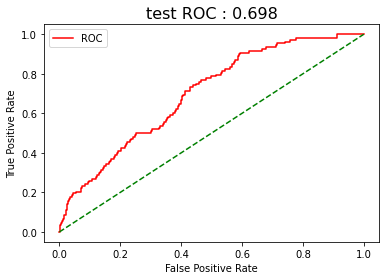

train_f1 score:  0.3452787258248009
test_f1 score:  0.14168039538714994 

train_recall score:  0.9743178170144462
test_recall score:  0.39814814814814814 

train_pre score:  0.20981679917041135
test_pre score:  0.08617234468937876 

train acc score:  0.6734288551567599
test acc score:  0.7914331465172137 

오차행렬:
 [[1934  456]
 [  65   43]]

정확도: 0.7914
정밀도: 0.0862
재현율: 0.3981
F1: 0.1417
AUC: 0.6037


In [26]:
from lightgbm import LGBMClassifier
import os
import time

start_time=time.time()

model = LGBMClassifier(
                       scale_pos_weight=20,
                       learning_rate=0.1, 
                       num_iterations = 1000, # n_estimator 랑 같은 것 같음
                       max_depth =4,
                       n_jobs=30,
                       boost_from_average=False)

trained_model = model.fit( trainX, trainY, 
          eval_set=[(testX,testY)],
          early_stopping_rounds=30, 
          verbose = 5, 
          eval_metric = 'auc')

train_pred_20 = trained_model.predict(trainX)
train_prob_20 = trained_model.predict_proba(trainX)[:, 1]

test_pred_20 = trained_model.predict(testX)
test_prob_20 = trained_model.predict_proba(testX)[:, 1]

plot_roc_curve(trainY, testY, train_pred_20, test_pred_20, train_prob_20, test_prob_20)
get_clf_eval(testY, test_pred_20)


In [24]:
pd.DataFrame(testY).value_counts()

0    2390
1     108
dtype: int64

In [99]:
TP=[]
FP=[]
TN=[]
FN=[]
for prob, pred, label in zip(test_prob_20, test_pred_20, testY):
    if pred == 1 and label ==1:
        TP.append(prob)
    elif pred == 0 and label ==1:
        FP.append(prob)
    elif pred == 0 and label ==0:
        TN.append(prob)
    elif pred == 1 and label ==0:
        FN.append(prob)

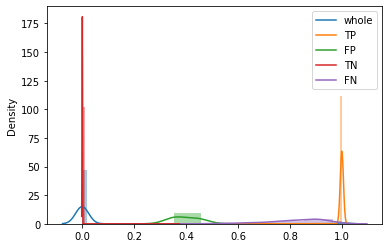

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
# fig = plt.figure(figsize(10,10))

sns.distplot(test_prob_20)
sns.distplot(TP)
sns.distplot(FP)
sns.distplot(TN)
sns.distplot(FN)
plt.legend(labels = ['whole', 'TP', 'FP', 'TN','FN'])

In [101]:
len(np.array(test_prob_20))

56060

In [102]:
sum(np.array(TP)>0.8)

2896

In [103]:
sum(np.array(FN)>0.8)

55